In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [7]:
# The range of values for aggressive and normal driving styles where given by GPT-3
parameters = {
    "minGap": {"min": 0, "max": None, "agg_min": 0, "agg_max": 0.5, "norm_min": 1.0, "norm_max": 2.0},  # Minimum gap from another vehicle when standing
    "accel": {"min": 0, "max": None, "agg_min": 2.0, "agg_max": 5.0, "norm_min": 1.0, "norm_max": 2.0},  # Acceleration ability of the vehicle type
    "decel": {"min": 0, "max": None, "agg_min": 2.0, "agg_max": 5.0, "norm_min": 1.0, "norm_max": 2.0},  # Deceleration ability of the vehicle type
    "startupDelay": {"min": 0, "max": None, "agg_min": 0, "agg_max": 0.5, "norm_min": 0.5, "norm_max": 1.0},  # Extra time before starting to drive after having to stop (not applied to scheduled stop)
    "sigma": {"min": 0, "max": 1, "agg_min": 0.5, "agg_max": 1.0, "norm_min": 0.0, "norm_max": 0.3},  # Driver imperfection (0 for perfect)
    "tau": {"min": 0, "max": None, "agg_min": 0.5, "agg_max": 1.0, "norm_min": 1.5, "norm_max": 2.0},  # The driver's desired minimum time headway (how closely it's willing to follow the car ahead)
    "maxSpeed": {"min": 0, "max": None, "agg_min": 100, "agg_max": 130, "norm_min": 80, "norm_max": 100},  # Vehicle maximum velocity
    "speedFactor": {"min": 0, "max": None, "agg_min": 1.5, "agg_max": 2.0, "norm_min": 1.0, "norm_max": 1.5},  # Vehicle's expected multiplier for lane speed limits and desiredMaxSpeed
    "lcStrategic": {"min": 0, "max": None, "agg_min": 5.0, "agg_max": 10.0, "norm_min": 1.0, "norm_max": 3.0},  # The eagerness for performing strategic lane changing (higher values result in earlier lane-changing)
    "lcCooperative": {"min": 0, "max": 1, "agg_min": 0.0, "agg_max": 0.2, "norm_min": 0.4, "norm_max": 0.8},  # The willingness for performing cooperative lane changing. Lower values result in reduced cooperation.
    "lcSpeedGain": {"min": 0, "max": None, "agg_min": 5.0, "agg_max": 10.0, "norm_min": 1.0, "norm_max": 3.0},  # The eagerness for performing lane changing to gain speed. Higher values result in more lane-changing
    "lcKeepRight": {"min": 0, "max": None, "agg_min": 1.0, "agg_max": 5.0, "norm_min": 0.5, "norm_max": 1.0},  # The eagerness for following the obligation to keep right. Higher values result in earlier lane-changing. default: 1.0, range [0-inf)
    "lcOvertakeRight": {"min": 0, "max": 1, "agg_min": 0.5, "agg_max": 1.0, "norm_min": 0.0, "norm_max": 0.2},  # The probability for violating rules against overtaking on the right. default: 0, range [0-1]
    "lcSpeedGainLookahead": {"min": 0, "max": None, "agg_min": 2.0, "agg_max": 5.0, "norm_min": 1.0, "norm_max": 2.0},  # Time in seconds for anticipating slowdown. By "looking ahead," the driver can anticipate if the current lane or the adjacent lanes will slow down in the near future.
    "lcOvertakeDeltaSpeedFactor": {"min": -1, "max": 1, "agg_min": 0.5, "agg_max": 1.0, "norm_min": -0.5, "norm_max": 0.5},  # Speed difference factor for the eagerness of overtaking a neighbor vehicle before changing lanes.
    "lcPushy": {"min": 0, "max": 1, "agg_min": 0.5, "agg_max": 1.0, "norm_min": 0.0, "norm_max": 0.2},  # Willingness to encroach laterally on other drivers. default: 0, range [0-1]
    "lcAssertive": {"min": 1, "max": None, "agg_min": 2.0, "agg_max": 5.0, "norm_min": 1.0, "norm_max": 1.5},  # Willingness to accept lower front and rear gaps on the target lane. The required gap is divided by this value. default: 1, range: positive reals
    "lcImpatience": {"min": -1, "max": 1, "agg_min": 0.5, "agg_max": 1.0, "norm_min": 0.0, "norm_max": 0.2},  # Dynamic factor for modifying lcAssertive and lcPushy. default: 0 (no effect). Impatience acts as a multiplier.
    "lcTimeToImpatience": {"min": 0, "max": None, "agg_min": 5.0, "agg_max": 10.0, "norm_min": 10.0, "norm_max": 20.0},  # Time to reach maximum impatience (of 1). Impatience grows whenever a lane-change maneuver is blocked. default: infinity (disables impatience growth)
    "lcLaneDiscipline": {"min": 0, "max": None, "agg_min": 1.0, "agg_max": 3.0, "norm_min": 0.0, "norm_max": 1.0},  # Reluctance to perform speedGain-changes that would place the vehicle across a lane boundary. default: 0.0
    "lcSigma": {"min": 0, "max": 1, "agg_min": 0.5, "agg_max": 1.0, "norm_min": 0.0, "norm_max": 0.2},  # Lateral positioning-imperfection. default: 0.0. Greater value means more imperfections
    "lcAccelLat": {"min": 0, "max": None, "agg_min": 1.0, "agg_max": 3.0, "norm_min": 0.5, "norm_max": 1.0},  # Maximum lateral acceleration per second. Together with maxSpeedLat this constrains lateral movement speed.
}


In [26]:
def getParamValue(parameter, style):
    # Currently supported styles are "agg" for aggressive and "norm" for normal
    if style not in ["agg", "norm"]:
        raise ValueError("Style must be either 'agg' or 'norm'")
    
    m = (parameters[parameter][f"{style}_max"] + parameters[parameter][f"{style}_min"])/2
    s = (parameters[parameter][f"{style}_max"] - m) / stats.norm.ppf(0.975) # Finding the standard deviation for 95% of the data to be within the range
    value = np.round(np.random.normal(m, s), 2)


    # Verificando se o valor gerado está dentro do intervalo permitido
    if value < parameters[parameter]["min"]:
        return parameters[parameter]["min"]
    elif value > parameters[parameter]["max"]:
        return parameters[parameter]["max"]
    
    probability = stats.norm.cdf(value, loc=m, scale=s)
    
    return value, probability

4.0


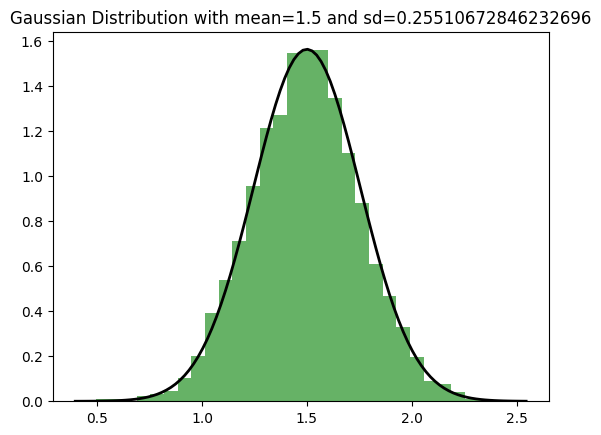

In [29]:
print(getParamValue("accel", "agg"))

param = "accel"
style = "norm"
m = (parameters[param][f"{style}_max"] + parameters[param][f"{style}_min"])/2
s = (parameters[param][f"{style}_max"] - m) / stats.norm.ppf(0.975) # Finding the standard deviation for 95% of the data to be within the range

# Generate data
data = np.random.normal(m, s, 5000)

# Plot the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5*((x - m) / s)**2) / (s * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
plt.title(f'Gaussian Distribution with mean={m} and sd={s}')
plt.show()